Установка необходимых библиотек:

In [ ]:
!pip install catboost
!pip install shap

Импорт библиотек и установка сида:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import shap
import math

SEED = 42

Загрузка данных, задание типа колонок

In [5]:
dir = 'drive/My Drive/Colab Notebooks/CSC/Projects/REZ_8/'
df = pd.read_csv(dir + 'flats.csv', index_col = 0)
str_columns = ['address', 'desc']
cat_columns = ['company', 'agent', 'renovation', 'balcony', 'view', 'bathroom', 'hot_water', 'heating', 'stove', 
               'house_type', 'elevator', 'entrance', 'parking', 'security', 'close_metro1', 'close_metro2',
               'close_railway1', 'close_railway2', 'how_selled', 'metro', 'name', 'area', 'district', 'unit']
int_columns = ['storeys', 'year_built', 'year_repaired', 'n_updates', 'first_price', 'last_price', 'owner',
               'online_display', 'top', 'up', 'color', 'day', 'warn', 'storey']
float_columns = ['total_area', 'living_area', 'kitchen_area', 'ceiling_height', 'close_metro1_dist',
                 'close_metro2_dist', 'close_railway1_dist', 'close_railway2_dist']
datetime_columns = ['first_seen', 'last_seen']
for col in str_columns:
    df[col] = df[col].astype('str')
for col in cat_columns:
    df[col] = df[col].astype('category')
for col in int_columns:
    df[col] = df[col].astype('float').astype('Int64')
for col in float_columns:
    df[col] = df[col].astype('float')
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], dayfirst = True)

Общий препроцессинг датасета

In [6]:
# name: заменить строковые обозначения на кол-во комнат (студия - 0 комнат)
df['name'] = df['name'].astype('object')
df.loc[df['name'] == 'Апартаменты-cтудия', 'name'] = '0'
df.loc[df['name'] == 'Комната в 3 ккв', 'name'] = '0'
df.loc[df['name'] == 'Студия', 'name'] = '0'
df['name'] = df['name'].str.split(expand=True)[0]
df['name'] = df['name'].astype('int')
# agent: слишком много разных агентов, закодируем просто, как есть агент или нет
df['agent'] = pd.isnull(df['agent']) == False
# address, desc: удалим эти колонки
df = df.drop(['address', 'desc'], axis = 1)
# elevator, entrance, parking, how_selled хоть и нуждаются в обработке (они представляют собой список характеристик), но не будут обрабатаны

Исправление датасета: удаление "некорректных" объявлений. Предполагаем, что "некорректные" наблюдения - это ошибки людей при создании объявлений. 

In [7]:
print('изначальное количество наблюдений:', df.shape[0])
# маловероятно, что площадь квартиры будет больше 1000 кв. м, если в ней меньше 4-х комнат
correct = ((df['total_area'] > 1000) & (df['name'] < 4)) == False
df = df[correct]
print('кол-во наблюдений после фильтрации по общей площади:', df.shape[0])
# общая площадь не может быть меньше жилой площади/площади кухни
correct = (df['total_area'] < df['living_area']) | (df['total_area'] < df['kitchen_area']) == False
df = df[correct]
print('кол-во наблюдений после фильтрации по жилой площади и кухне:', df.shape[0])
# маловероятно, что площадь потолка будет больше 10 метров
correct = (df['ceiling_height'] > 10) == False
df = df[correct]
print('кол-во наблюдений после фильтрации по высоте потолков:', df.shape[0])
# этаж квартиры не может быть больше этажности дома
correct = ((df['storey'] > df['storeys']) == False).fillna(True)
df = df[correct]
# маловероятно, что этаж квартиры будет больше 40
correct = ((df['storey'] > 40) == False).fillna(True)
df = df[correct]
print('кол-во наблюдений после фильтрации по этажам:', df.shape[0])
# рассматриваем только дома, которые уже были построены
correct = ((df['year_built'] > 2021) == False).fillna(True)
df = df[correct]
correct = ((df['year_repaired'] > 2021) == False).fillna(True)
df = df[correct]
print('кол-во наблюдений после фильтрации по годам постройки и ремонта:', df.shape[0])
# маловероятно, что квартира, в которой три или меньше комнат, будет стоить больше 100 миллионов
correct = (((df['last_price'] > 100000000) & (df['name'] < 3)) == False)
df = df[correct]
print('кол-во наблюдений после фильтрации по цене:', df.shape[0])

изначальное количество наблюдений: 24424
кол-во наблюдений после фильтрации по общей площади: 24394
кол-во наблюдений после фильтрации по жилой площади и кухне: 24391
кол-во наблюдений после фильтрации по высоте потолков: 24385
кол-во наблюдений после фильтрации по этажам: 24381
кол-во наблюдений после фильтрации по годам постройки и ремонта: 24350
кол-во наблюдений после фильтрации по цене: 24348


Посмотрим на долю пропущенных значений в каждом столбце:

In [8]:
print(df.isnull().sum()/df.shape[0])

name                   0.000000
area                   0.000000
district               0.000082
unit                   0.000082
company                0.000000
agent                  0.000000
total_area             0.000000
living_area            0.000000
kitchen_area           0.070683
ceiling_height         0.234639
renovation             0.236077
balcony                0.466116
view                   0.863521
bathroom               0.445416
hot_water              0.873172
heating                0.934492
stove                  0.953179
storey                 0.001150
storeys                0.001150
house_type             0.001191
year_built             0.210325
year_repaired          0.990554
elevator               0.614794
entrance               0.957574
parking                0.992607
security               0.990718
close_metro1           0.222031
close_metro1_dist      0.222031
close_metro2           0.222031
close_metro2_dist      0.222031
close_railway1         0.222031
close_ra

Попытаемся решить две задачи: 
1.   Предсказание цены квартиры
2.   Предсказание времени продажи квартиры.

Обе задачи имеют практическое применение и направлены на улучшение сервиса для продавцев квартир на сайтах недвижимости. Продавцу можно подсказывать "адекватную" (относительно характеристик квартиры и существующих объявлений) цену, а также показывать приблизительное время продажи квартиры при такой цене.

**1-ая задача: предсказание "адекватной" цены квартиры.**

Будем предсказывать цену за квадратный метр, оценивать метрику MAPE (mean absolute percentage error), валидироваться на 20 процентах отложенной выборки.

In [27]:
# метрика
def mean_absolute_percentage_error(y_true, y_pred):
    '''Рассчитывает метрику MAPE'''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [9]:
y = df['last_price']/df['total_area'].copy()
X = df.drop(['first_price', 'first_seen', 'last_seen', 'last_price'], axis = 1).copy()
nans_features = ['entrance', 'parking', 'security', 'heating', 'stove', 
                 'hot_water', 'view', 'year_repaired'] # признаки с долей пропущенных значений > 0.8, удалим их
X = X.drop(nans_features, axis = 1).copy() 
X['owner'] = X['owner'].astype('category')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [ ]:
# перевод некоторых в столбцов в категориальную форму, инициализация модели
cat_features = list(X.select_dtypes(['category']).columns)
for cat_feature in cat_features:
    X_train[cat_feature] = X_train[cat_feature].astype('str')
    X_test[cat_feature] = X_test[cat_feature].astype('str')
for feature in set(X.columns) - set(cat_features):
    X_train[feature] = X_train[feature].astype('float')
    X_test[feature] = X_test[feature].astype('float')
y_train = y_train.astype('float')
y_test = y_test.astype('float')
model = CatBoostRegressor(cat_features=cat_features, loss_function='RMSE', iterations = 500, random_seed = SEED)

In [13]:
model.fit(X_train, y_train, verbose = 500)

Learning rate set to 0.11213
0:	learn: 63919.5708441	total: 40.5ms	remaining: 20.2s
499:	learn: 23730.5507326	total: 21.1s	remaining: 0us


In [17]:
y_pred = model.predict(X_test)
print('MAPE:', "%.2f" % mean_absolute_percentage_error(y_test, y_pred), '%')

MAPE: 10.39 %


Средняя ошибка - 10 %, что кажется приемлимым результатом.

Теперь попробуем посмотреть на значимость признаков. Воспользуемся значениями вектора Шепли, посчитанными с помощью библиотеки SHAP.

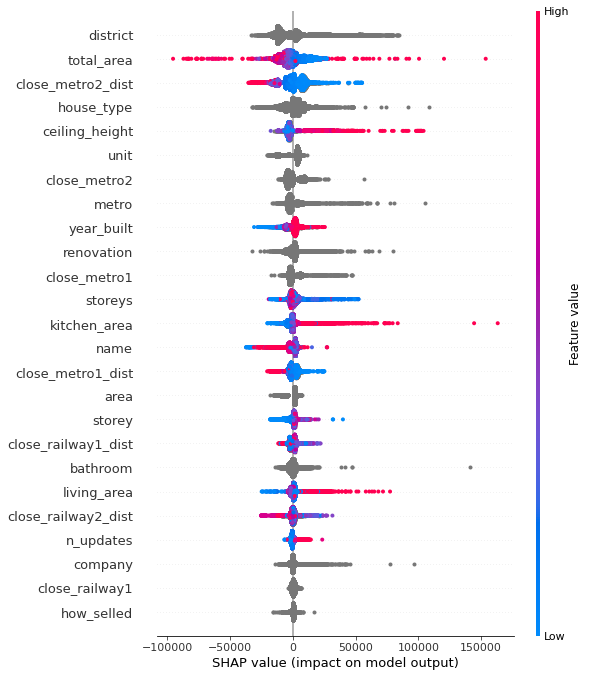

In [18]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, max_display = 25)

Самыми значимыми признаками оказалось: район, общая площадь квартиры, расстояние до второй ближайшей станции метро, тип дома, высота потолков.

Логичные интерпретации значимости признаков получились:
*   у высоты потолков, площади кухни, жилой площади, времени постройки дома: чем эти признаки больше, тем выше оценивается квартира. 
*   у расстояния до ближайшей станции метро, количества этажей в доме, расстояния до ближайшей ЖД станции: чем эти признаки больше, тем ниже оценивается квартира.

Не совсем ясна ситуация со значением у количества комнат (name) и общей площади квартиры: увеличение этих признаков не сказывается положительно на стоимости квартиры. Возможно это объясняется тем, что квартиры с большим количеством комнат и внушительной площадью часто оказываются бывшими коммуналками, требующими больших вложений. Из-за этого они относительно низко оцениваются рынком.

**2-ая задача: предсказание времени продажи квартиры.**

Делаем смелое предположение: квартира, которая более 3 дней отсутствует на сайте - была продана. 

Фильтруем датасет и рассчитываем время, потребовавшееся на продажу квартиры. Будем предсказывать это значение, оценивать метрику RMSE (Root Mean Square Error) и валидироваться на 20 процентах отложенной выборки.

In [ ]:
sold = df[df['last_seen'] <= '2021-05-15']
sold['time_to_sell'] = (sold['last_seen'] - sold['first_seen']).dt.days
y = sold['time_to_sell'].copy()
X = sold.drop(['first_price', 'first_seen', 'last_seen'], axis = 1).copy()
cheat_features = ['n_updates', 'online_display', 'top', 'up', 'color', 'day', 'warn']
for cheat_feature in cheat_features:
    X[cheat_feature] = X[cheat_feature]/(X['time_to_sell'] + 1) # переведм фичи, связанные с продвижением, из количества в доли
X = X.drop(['time_to_sell'], axis = 1).copy()
nans_features = ['entrance', 'parking', 'security', 'heating', 'stove',
                 'hot_water', 'view', 'year_repaired'] # features with a lot of nans (> 0.8)
X = X.drop(nans_features, axis = 1).copy()
X['owner'] = X['owner'].astype('category')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [ ]:
# перевод некоторых в столбцов в категориальную форму, инициализация модели
cat_features = list(X.select_dtypes(['category']).columns)
for cat_feature in cat_features:
    X_train[cat_feature] = X_train[cat_feature].astype('str')
    X_test[cat_feature] = X_test[cat_feature].astype('str')
for feature in set(X.columns) - set(cat_features):
    X_train[feature] = X_train[feature].astype('float')
    X_test[feature] = X_test[feature].astype('float')
y_train = y_train.astype('float')
y_test = y_test.astype('float')
model = CatBoostRegressor(cat_features=cat_features, loss_function='RMSE', iterations = 1000, random_seed=SEED)

In [25]:
model.fit(X_train, y_train, verbose = 500)

Learning rate set to 0.055552
0:	learn: 7.3483360	total: 23.5ms	remaining: 23.5s
500:	learn: 3.6307861	total: 10.1s	remaining: 10.1s
999:	learn: 3.0621957	total: 20.5s	remaining: 0us


In [26]:
y_pred = model.predict(X_test)
print('RMSE:', "%.2f" % math.sqrt(mean_squared_error(y_test, y_pred)), 'дней')

RMSE: 4.27 дней


Средняя ошибка модели - 4 дня, средняя ошибка при предсказании средними - 7 дней. Кажется, что модель незначительно улучшает результат. Для дальнейших выводов нужно больше данных.

Теперь попробуем посмотреть на значимость признаков. Воспользуемся значениями вектора Шепли, посчитанными с помощью библиотеки SHAP.

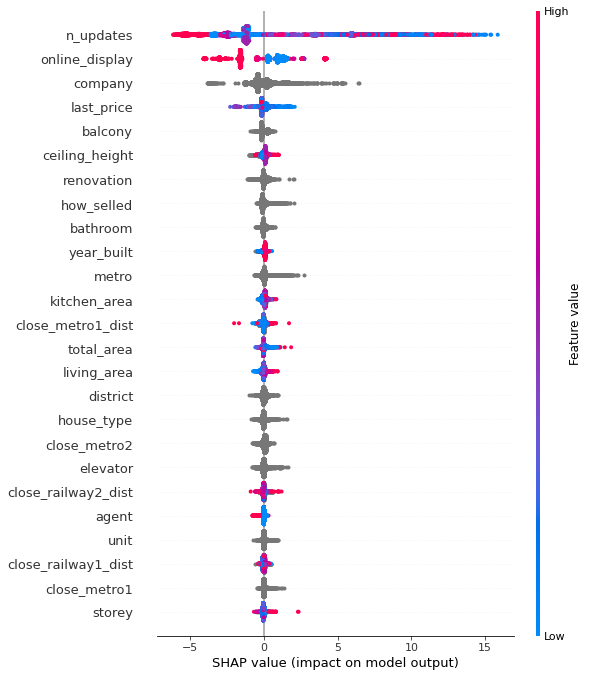

In [28]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, max_display = 25)

Самыми значимыми признаками оказалось: частота обновлений объявления, частота проведения онлайн-показов, компания, продающая квартиру, цена, по которой продается квартира.

Из графика видна значимость постоянных обновлений объявления для продажи квартиры: алгоритмы bn.ru выводят в верх поиска регулярно обновляющиеся объявления. Также на ускорение продажи квартиры работают регулярно проводимые онлайн-показы.